# Based on the "Real Life Industrial Dataset of Casting Product" from Kaggle

https://www.kaggle.com/code/koheimuramatsu/model-explainability-in-industrial-image-detection/input


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import drive
from google.colab import files
from torchvision.models import resnet18
import torchsummary
import time
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

In [16]:
DATASET_PATH = '/content/drive/MyDrive/casting_data/casting_data'
TRAIN_PATH = f'{DATASET_PATH}/train'
TEST_PATH = f'{DATASET_PATH}/test'


In [20]:
class CastingDataset(Dataset):
    def __init__(self, defect_dir, ok_dir, transform=None):
        self.transform = transform

        # Load defective images
        self.defect_images = [os.path.join(defect_dir, img) for img in os.listdir(defect_dir) if img.endswith('.jpeg')]

        # Load OK images
        self.ok_images = [os.path.join(ok_dir, img) for img in os.listdir(ok_dir) if img.endswith('.jpeg')]

        # Combine all images and labels
        self.all_images = self.defect_images + self.ok_images
        self.labels = [1] * len(self.defect_images) + [0] * len(self.ok_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_path = self.all_images[idx]
        label = self.labels[idx]

        # Load image and apply transformations
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label


In [21]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [27]:
train_dataset = CastingDataset(
    defect_dir=f'{TRAIN_PATH}/def_front',
    ok_dir=f'{TRAIN_PATH}/ok_front',
    transform=train_transforms)

test_dataset = CastingDataset(
    defect_dir=f'{TEST_PATH}/def_front',
    ok_dir=f'{TEST_PATH}/ok_front',
    transform=test_transforms)


train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,  # Number of subprocesses for data loading
    pin_memory=True  # Use pinned memory for faster transfers to GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [28]:
class CastingDefectCNN(nn.Module):
    def __init__(self):
        super(CastingDefectCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2)

        # Calculate the size of flattened features
        self.fc_input_features = 128 * 14 * 14

        self.fc1 = nn.Linear(self.fc_input_features, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)  # Two classes: defective and OK

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        x = x.view(-1, self.fc_input_features)
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)

        return x

model = CastingDefectCNN()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CastingDefectCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (re

In [29]:
# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [30]:
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0

        with tqdm(train_loader) as pbar:
            pbar.set_description(f"Epoch {epoch+1}/{num_epochs}")

            for inputs, labels in pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                pbar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

train_model(model, train_loader, criterion, optimizer, device)


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 1 Loss: 2.9301


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 2 Loss: 0.2142


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 3 Loss: 0.1868


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 4 Loss: 0.2607


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 5 Loss: 0.2909


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 6 Loss: 0.2260


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 7 Loss: 0.4040


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 8 Loss: 0.0999


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 9 Loss: 0.1117


  0%|          | 0/208 [00:00<?, ?it/s]

Epoch 10 Loss: 0.1827


In [33]:
# Function to evaluate the model
def evaluate_model(model, test_loader, criterion, device):
    model.eval()

    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate test loss and accuracy
    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100. * sum(1 for x, y in zip(all_predictions, all_labels) if x == y) / len(all_labels)

    # Generate classification report
    report = classification_report(all_labels, all_predictions, target_names=['OK', 'Defective'])

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    return test_loss, test_accuracy, report, cm, all_labels, all_predictions

In [10]:
# Function to visualize predictions
def visualize_predictions(model, test_loader, device, num_images=10):
    # Get a batch of test images
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # Make predictions
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Move tensors to CPU for visualization
    images = images.cpu()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # Plot the images with predictions and true labels
    fig = plt.figure(figsize=(15, 8))
    for idx in range(min(num_images, len(images))):
        ax = fig.add_subplot(2, num_images//2, idx+1, xticks=[], yticks=[])
        # Convert tensor to numpy and transpose for display
        img = images[idx].numpy().transpose((1, 2, 0))

        # Denormalize the image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        # Display the image
        ax.imshow(img)

        # Add title with prediction and true label
        title_color = 'green' if preds[idx] == labels[idx] else 'red'
        pred_label = 'Defective' if preds[idx] == 1 else 'OK'
        true_label = 'Defective' if labels[idx] == 1 else 'OK'
        ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=title_color)

    plt.tight_layout()
    plt.show()

In [11]:
# Visualize training performance
def plot_training_performance(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


In [12]:
# Visualize confusion matrix
def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['OK', 'Defective'], yticklabels=['OK', 'Defective'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


Test Loss: 0.5594
Test Accuracy: 90.35%

Classification Report:
              precision    recall  f1-score   support

          OK       0.79      1.00      0.88       262
   Defective       1.00      0.85      0.92       453

    accuracy                           0.90       715
   macro avg       0.90      0.92      0.90       715
weighted avg       0.92      0.90      0.91       715



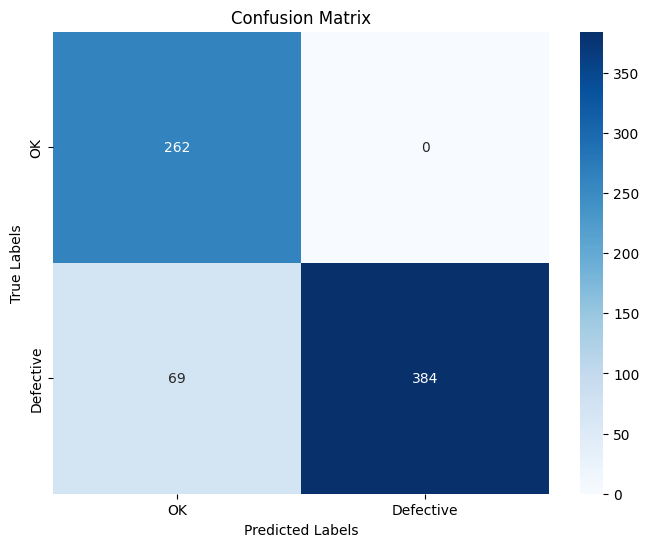

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


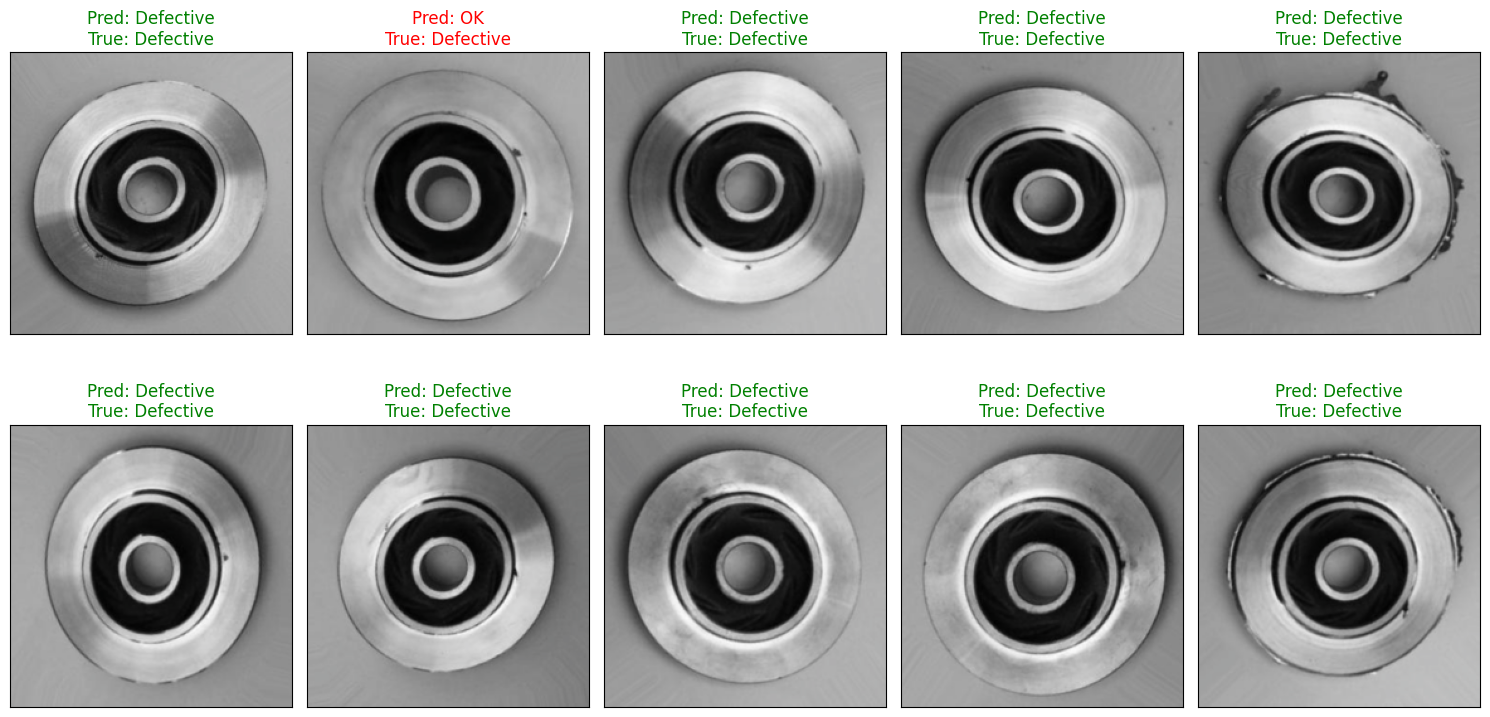

In [37]:
test_loss, test_accuracy, report, cm, all_labels, all_predictions = evaluate_model(
        model, test_loader, criterion, device)

    # Print evaluation results
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print("\nClassification Report:")
print(report)

    # Plot confusion matrix
plot_confusion_matrix(cm)

    # Visualize some predictions
visualize_predictions(model, test_loader, device, num_images=10)

In [32]:
torch.save(model.state_dict(), '/content/drive/MyDrive/casting_defect_cnn.pth')
print("Model saved to Google Drive")


Model saved to Google Drive
